In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils as utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
sns.set_theme()

In [2]:
latent_dims = 2
BATCH_SIZE = 100
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader = utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

val_loader = utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=BATCH_SIZE, shuffle=False)

In [4]:
batch, _ = next(iter(val_loader))

In [5]:
def print_digits(imgs, real_imgs, epoch):
    fig, axes = plt.subplots(2, 8, figsize=(18,6))
    for i in range(8):
        axes[0,i].imshow(imgs[i].reshape(28, 28), cmap='gray')
        axes[0,i].grid(False)
        axes[0,i].set_title(f"Epoch: {epoch}, Encoded")
    for i in range(8):
        axes[1,i].imshow(real_imgs[i].reshape(28, 28), cmap='gray')
        axes[1,i].grid(False)
        axes[1,i].set_title(f"Epoch: {epoch}, Real")

In [29]:
def kl_loss(pred, y, z_mean, z_sigma):
    mse_loss = nn.MSELoss(reduction='sum')
    MSE = mse_loss(pred, y)
    KLD = (z_sigma ** 2 + z_mean ** 2 - torch.log(z_sigma) - 1/2).sum() * 0.3
    return MSE + KLD

In [13]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 12)
        self.z_mean = nn.Linear(12, latent_dims)
        self.z_sigma = nn.Linear(12, latent_dims)

        self.eps = torch.distributions.Normal(0, 1)
        self.eps.loc = self.eps.loc.cuda() # hack to get sampling on the GPU
        self.eps.scale = self.eps.scale.cuda()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        z_mean =  self.z_mean(x)
        z_sigma = torch.exp(self.z_sigma(x))
        z = z_mean + z_sigma * self.eps.sample(z_mean.shape)
        #self.kl = (z_sigma ** 2 + z_mean ** 2 - torch.log(z_sigma) - 1/2).sum()
        return z, z_mean, z_sigma

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 12)
        self.linear2 = nn.Linear(12, 64)
        self.linear3 = nn.Linear(64, 128)
        self.linear4 = nn.Linear(128, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = F.relu(self.linear3(z))
        z = torch.sigmoid(self.linear4(z))
        return z.reshape((-1, 1, 28, 28))

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z, z_mean, z_sigma = self.encoder(x)
        return self.decoder(z), z_mean, z_sigma
    
    def fit(self, train_loader, val_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def _train(self, opt=None, loss_fn=kl_loss):
        self.opt = opt
        self.loss = []
        self.val_loss = []
        self.criterion = loss_fn
        self.outputs = []
        for i in range(EPOCHS):
            loss_pe = 0
            val_loss_pe = 0
            pred_val = None
            for X_train, _ in self.train_loader:
                X_train = X_train.to(device) # GPU
                self.opt.zero_grad()
                pred, z_mean, z_sigma = self(X_train)
                loss = self.criterion(pred, X_train, z_mean, z_sigma)

                loss_pe += loss.item()

                loss.backward()
                self.opt.step()
                
            self.eval()
                
            with torch.no_grad():
                for j, (X_val, _) in enumerate(self.val_loader):
                    X_val = X_val.to(device)
                    pred, z_mean, z_sigma = self(X_val)
                    
                    if j == 0:
                        pred_val = pred.cpu().detach()
                    
                    val_loss = self.criterion(pred, X_val, z_mean, z_sigma)
                    val_loss_pe += val_loss.item() * 6
                    
            print(f"Epoch: {i+1}, Loss: {loss_pe}, Val loss: {val_loss_pe}")
            self.loss.append(loss_pe)
            self.val_loss.append(val_loss_pe)
            self.outputs.append(pred_val)
            self.train()
    
    def plot_loss(self):
        plt.figure(figsize=(18,8))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        sns.lineplot(x=range(1, EPOCHS+1), y=self.loss, label='loss')
        sns.lineplot(x=range(1, EPOCHS+1), y=self.val_loss, label='val_loss')
        
    def plot_latent(self, num_batches=100):
        for i, (x, y) in enumerate(self.val_loader):
            z, _, _ = self.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break
                
    def plot_reconstructed(self, r0=(-5, 10), r1=(-10, 5), n=12):
        w = 28
        img = np.zeros((n*w, n*w))
        for i, y in enumerate(np.linspace(*r1, n)):
            for j, x in enumerate(np.linspace(*r0, n)):
                z = torch.Tensor([[x, y]]).to(device)
                x_hat = self.decoder(z)
                x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
                img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
        plt.imshow(img, extent=[*r0, *r1])
        
    def plot_outputs(self):
        for i, output in enumerate(self.outputs):
            print_digits(output, batch.to('cpu').detach(), i+1)

In [24]:
model = VariationalAutoencoder(latent_dims).to(device) # GPU
model.fit(train_loader, val_loader)
model._train(opt=optim.Adam(model.parameters(), lr=1e-3), loss_fn=kl_loss)

MSE: 18180.29296875
KLD: 112.17938232421875
MSE: 18028.271484375
KLD: 99.32147216796875
MSE: 17896.623046875
KLD: 90.54083251953125
MSE: 17748.958984375
KLD: 83.70520782470703
MSE: 17599.18359375
KLD: 79.43630981445312
MSE: 17440.953125
KLD: 76.61402893066406
MSE: 17230.44140625
KLD: 76.66537475585938
MSE: 17023.65234375
KLD: 77.81124877929688
MSE: 16789.0078125
KLD: 79.89094543457031
MSE: 16518.36328125
KLD: 83.61262512207031
MSE: 16273.552734375
KLD: 88.46391296386719
MSE: 15999.44921875
KLD: 91.99334716796875
MSE: 15558.4931640625
KLD: 99.60912322998047
MSE: 15225.884765625
KLD: 105.48578643798828
MSE: 14933.35546875
KLD: 114.53129577636719
MSE: 14295.4658203125
KLD: 143.69384765625
MSE: 13868.14453125
KLD: 149.42169189453125
MSE: 13209.244140625
KLD: 184.7950439453125
MSE: 12422.3505859375
KLD: 227.4874725341797
MSE: 12146.4013671875
KLD: 270.88677978515625
MSE: 11297.041015625
KLD: 360.37518310546875
MSE: 10670.701171875
KLD: 443.6602783203125
MSE: 9289.05078125
KLD: 644.290161132

KeyboardInterrupt: 

In [ ]:
model.plot_loss()

In [ ]:
model.plot_latent()

In [ ]:
model.plot_reconstructed(r0=(-3, 3), r1=(-3, 3))

In [ ]:
model.plot_outputs()

In [7]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1) # (N, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # (N, 64, 7, 7)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7) # (N, 128, 1, 1)
    
        self.z_mean = nn.Linear(128, latent_dims)
        self.z_sigma = nn.Linear(128, latent_dims)

        self.eps = torch.randn(BATCH_SIZE, latent_dims).to(device)
    def forward(self, x):
        x = F.relu(self.conv1(x)) # (N, 32, 14, 14)
        x = F.relu(self.conv2(x)) # (N, 64, 7, 7)
        x = self.conv3(x) # (N, 128, 1, 1)
        
        x = torch.flatten(x, start_dim=1) # (N, 128)
        
        z_mean = self.z_mean(x) # (N, 2)
        z_sigma = torch.exp(self.z_sigma(x)) # (N, 2)
        
        z = z_mean + z_sigma * self.eps # (N, 2)
        return z, z_mean, z_sigma

In [8]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(ConvDecoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=7) # (N, 32, 7, 7)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1) # (N, 32, 14, 14)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1) # (N, 1, 28, 28)

        self.linear1 = nn.Linear(latent_dims, 128)

    def forward(self, z):
        z = self.linear1(z) # (N, 64)
        z = z.reshape(-1, 128, 1, 1) # (N, 64, 1, 1)
        z = F.relu(self.conv1(z)) # (N, 32, 7, 7)
        z = F.relu(self.conv2(z)) # (N, 16, 14, 14)
        z = torch.sigmoid(self.conv3(z)) # (N, 1, 28, 28)
        return z

In [9]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dims):
        super(ConvVAE, self).__init__()
        self.encoder = ConvEncoder(latent_dims)
        self.decoder = ConvDecoder(latent_dims)

    def forward(self, x):
        z, z_mean, z_sigma = self.encoder(x)
        return self.decoder(z), z_mean, z_sigma
    
    def fit(self, train_loader, val_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def _train(self, opt=None, loss_fn=kl_loss):
        self.opt = opt
        self.loss = []
        self.val_loss = []
        self.criterion = loss_fn
        self.outputs = []
        for i in range(EPOCHS):
            loss_pe = 0
            val_loss_pe = 0
            pred_val = None
            for X_train, _ in self.train_loader:
                X_train = X_train.to(device) # GPU
                self.opt.zero_grad()
                pred, z_mean, z_sigma = self(X_train)
                loss = self.criterion(pred, X_train, z_mean, z_sigma)

                loss_pe += loss.item()

                loss.backward()
                self.opt.step()
                
            self.eval()
                
            with torch.no_grad():
                for j, (X_val, _) in enumerate(self.val_loader):
                    X_val = X_val.to(device)
                    pred, z_mean, z_sigma = self(X_val)
                    
                    if j == 0:
                        pred_val = pred.cpu().detach()
                    
                    val_loss = self.criterion(pred, X_val, z_mean, z_sigma)
                    val_loss_pe += val_loss.item() * 6
                    
            print(f"Epoch: {i+1}, Loss: {loss_pe}, Val loss: {val_loss_pe}")
            self.loss.append(loss_pe)
            self.val_loss.append(val_loss_pe)
            self.outputs.append(pred_val)
            self.train()
    
    def plot_loss(self):
        plt.figure(figsize=(18,8))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        sns.lineplot(x=range(1, EPOCHS+1), y=self.loss, label='loss')
        sns.lineplot(x=range(1, EPOCHS+1), y=self.val_loss, label='val_loss')
        
    def plot_latent(self, num_batches=100):
        for i, (x, y) in enumerate(self.val_loader):
            z, _, _ = self.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break
                
    def plot_reconstructed(self, r0=(-5, 10), r1=(-10, 5), n=12):
        w = 28
        img = np.zeros((n*w, n*w))
        for i, y in enumerate(np.linspace(*r1, n)):
            for j, x in enumerate(np.linspace(*r0, n)):
                z = torch.Tensor([[x, y]]).to(device)
                x_hat = self.decoder(z)
                x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
                img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
        plt.imshow(img, extent=[*r0, *r1])
        
    def plot_outputs(self):
        for i, output in enumerate(self.outputs):
            print_digits(output, batch.to('cpu').detach(), i+1)

In [30]:
conv_model = ConvVAE(latent_dims).to(device) # GPU
conv_model.fit(train_loader, val_loader)
conv_model._train(opt=optim.Adam(conv_model.parameters(), lr=1e-3), loss_fn=kl_loss)

Epoch: 1, Loss: 2804687.6850585938, Val loss: 2384394.9228515625
Epoch: 2, Loss: 2335612.0727539062, Val loss: 2283752.1020507812
Epoch: 3, Loss: 2267725.3513183594, Val loss: 2232431.2412109375
Epoch: 4, Loss: 2226296.6928710938, Val loss: 2210147.056640625
Epoch: 5, Loss: 2199763.2524414062, Val loss: 2179866.263671875
Epoch: 6, Loss: 2180070.3520507812, Val loss: 2173404.80859375
Epoch: 7, Loss: 2166795.201904297, Val loss: 2161514.1884765625
Epoch: 8, Loss: 2155632.8903808594, Val loss: 2149796.3041992188
Epoch: 9, Loss: 2148138.922607422, Val loss: 2143750.8310546875
Epoch: 10, Loss: 2138057.4899902344, Val loss: 2129899.8559570312


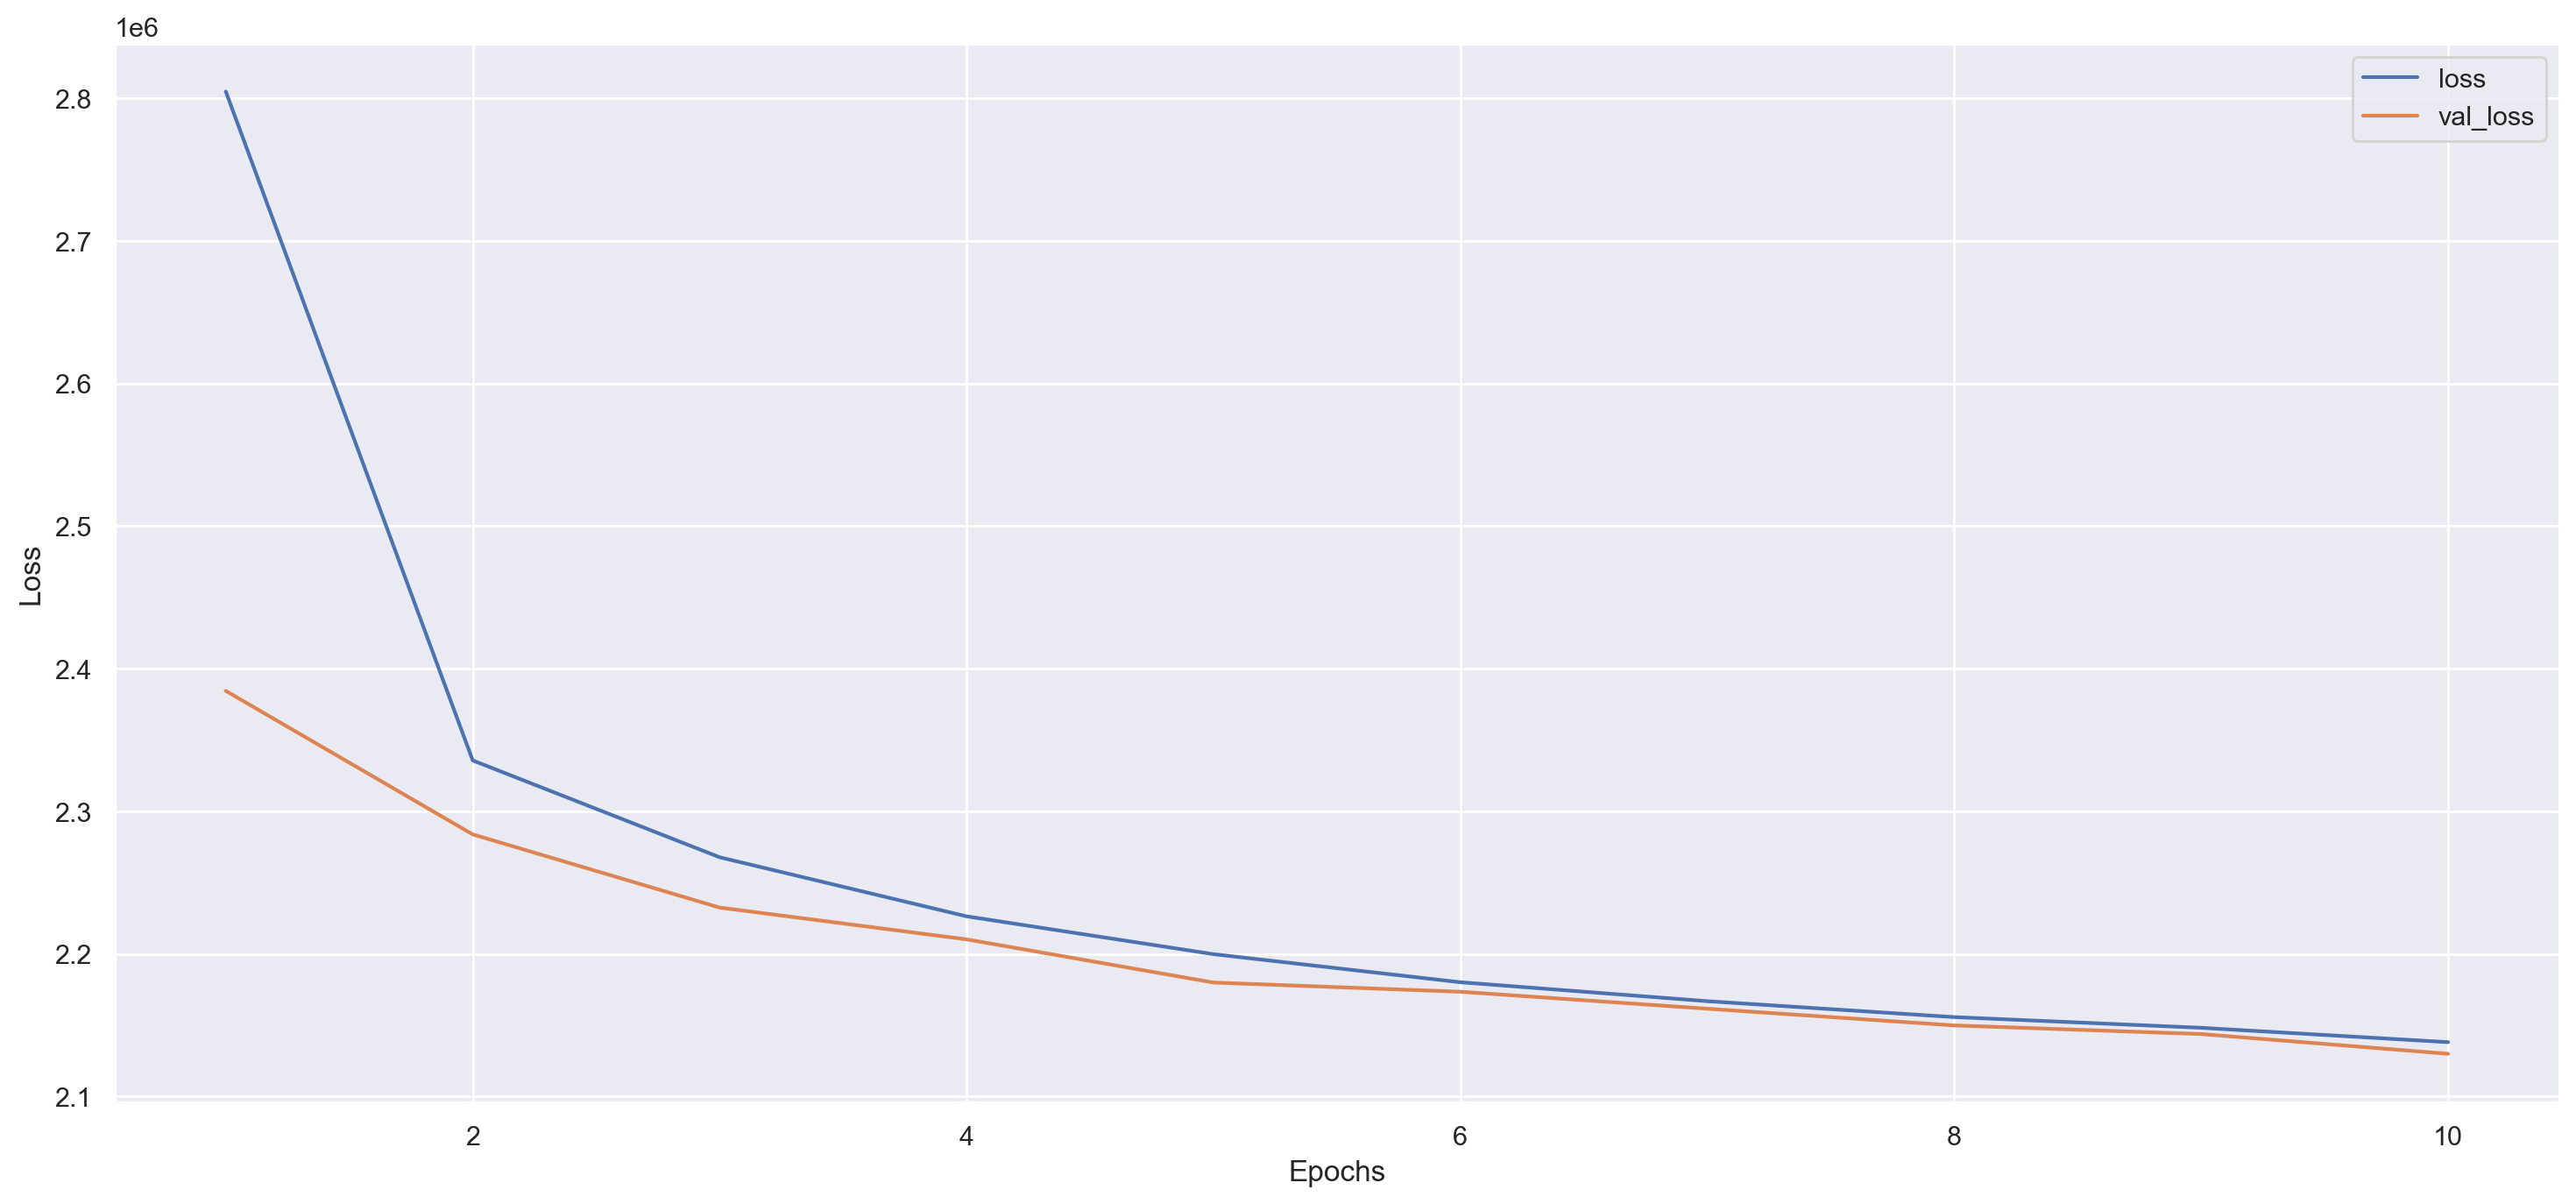

In [31]:
conv_model.plot_loss()

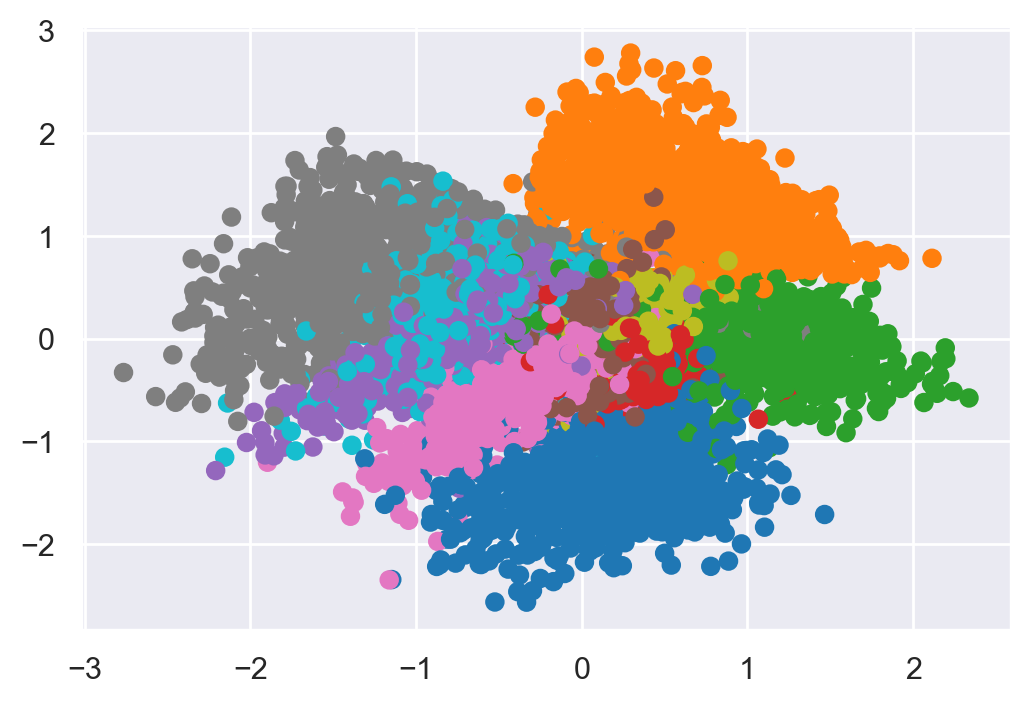

In [32]:
conv_model.plot_latent()

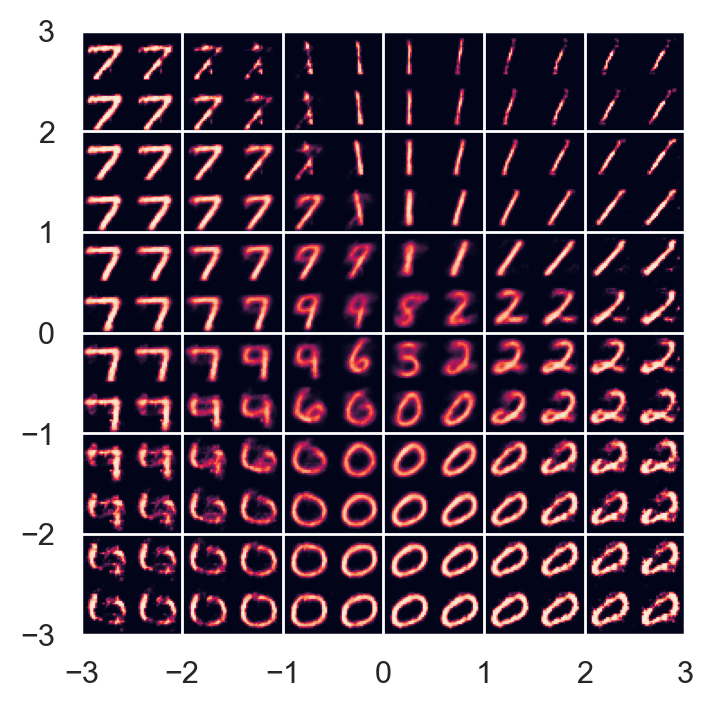

In [33]:
conv_model.plot_reconstructed(r0=(-3, 3), r1=(-3, 3))

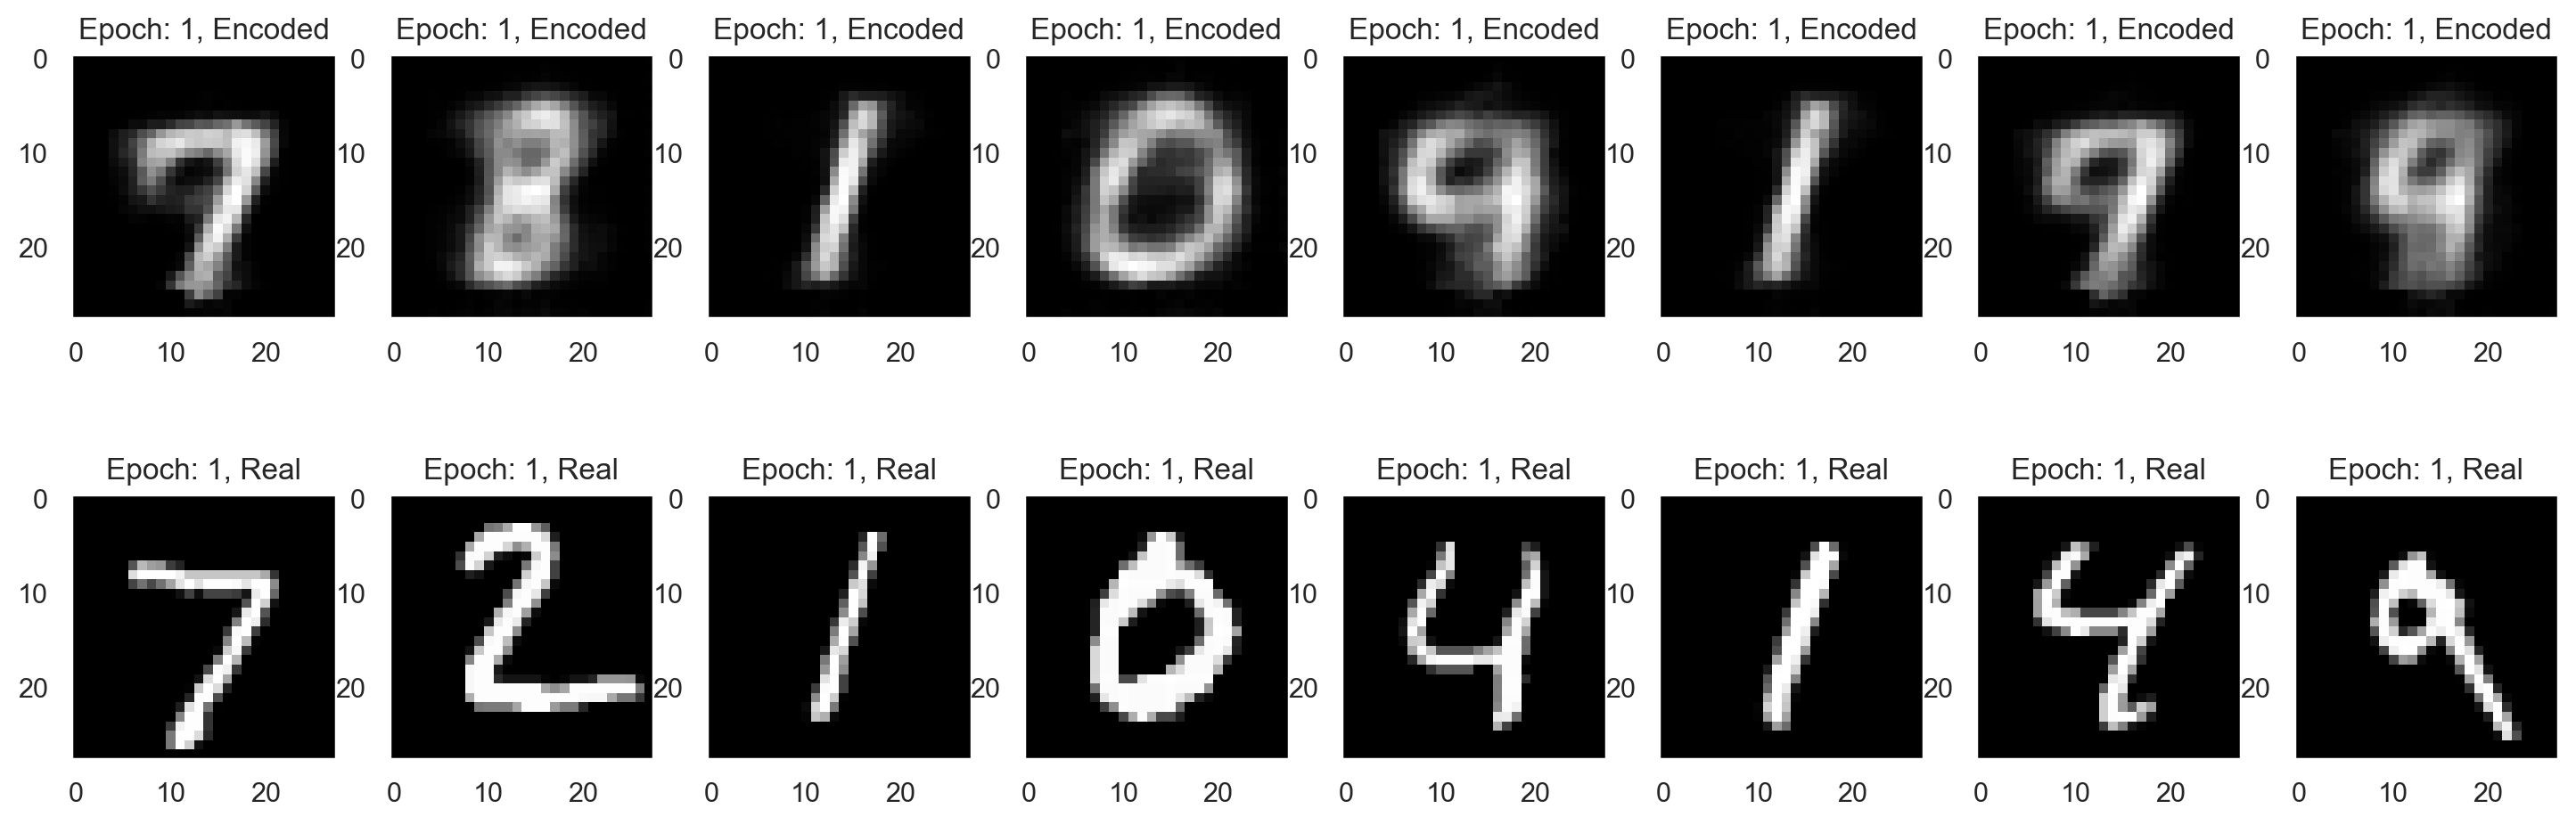

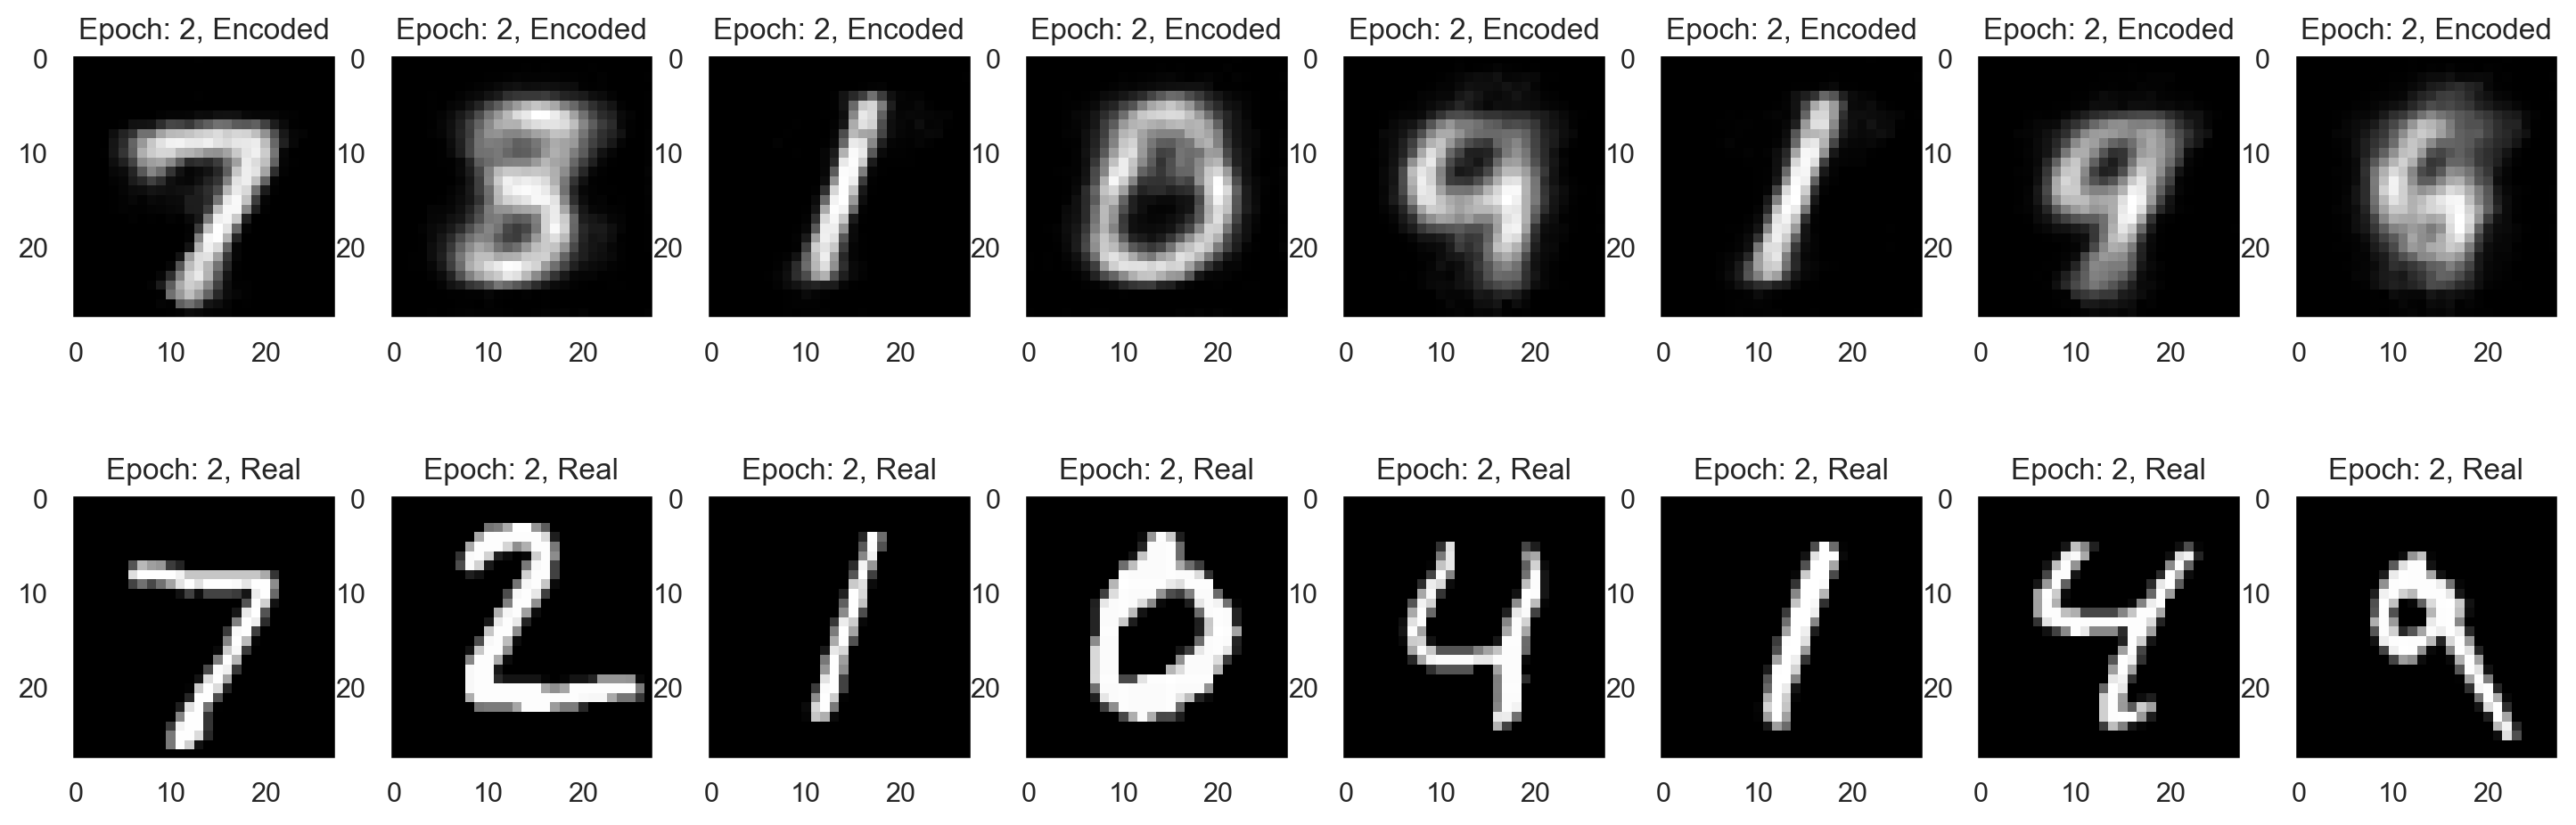

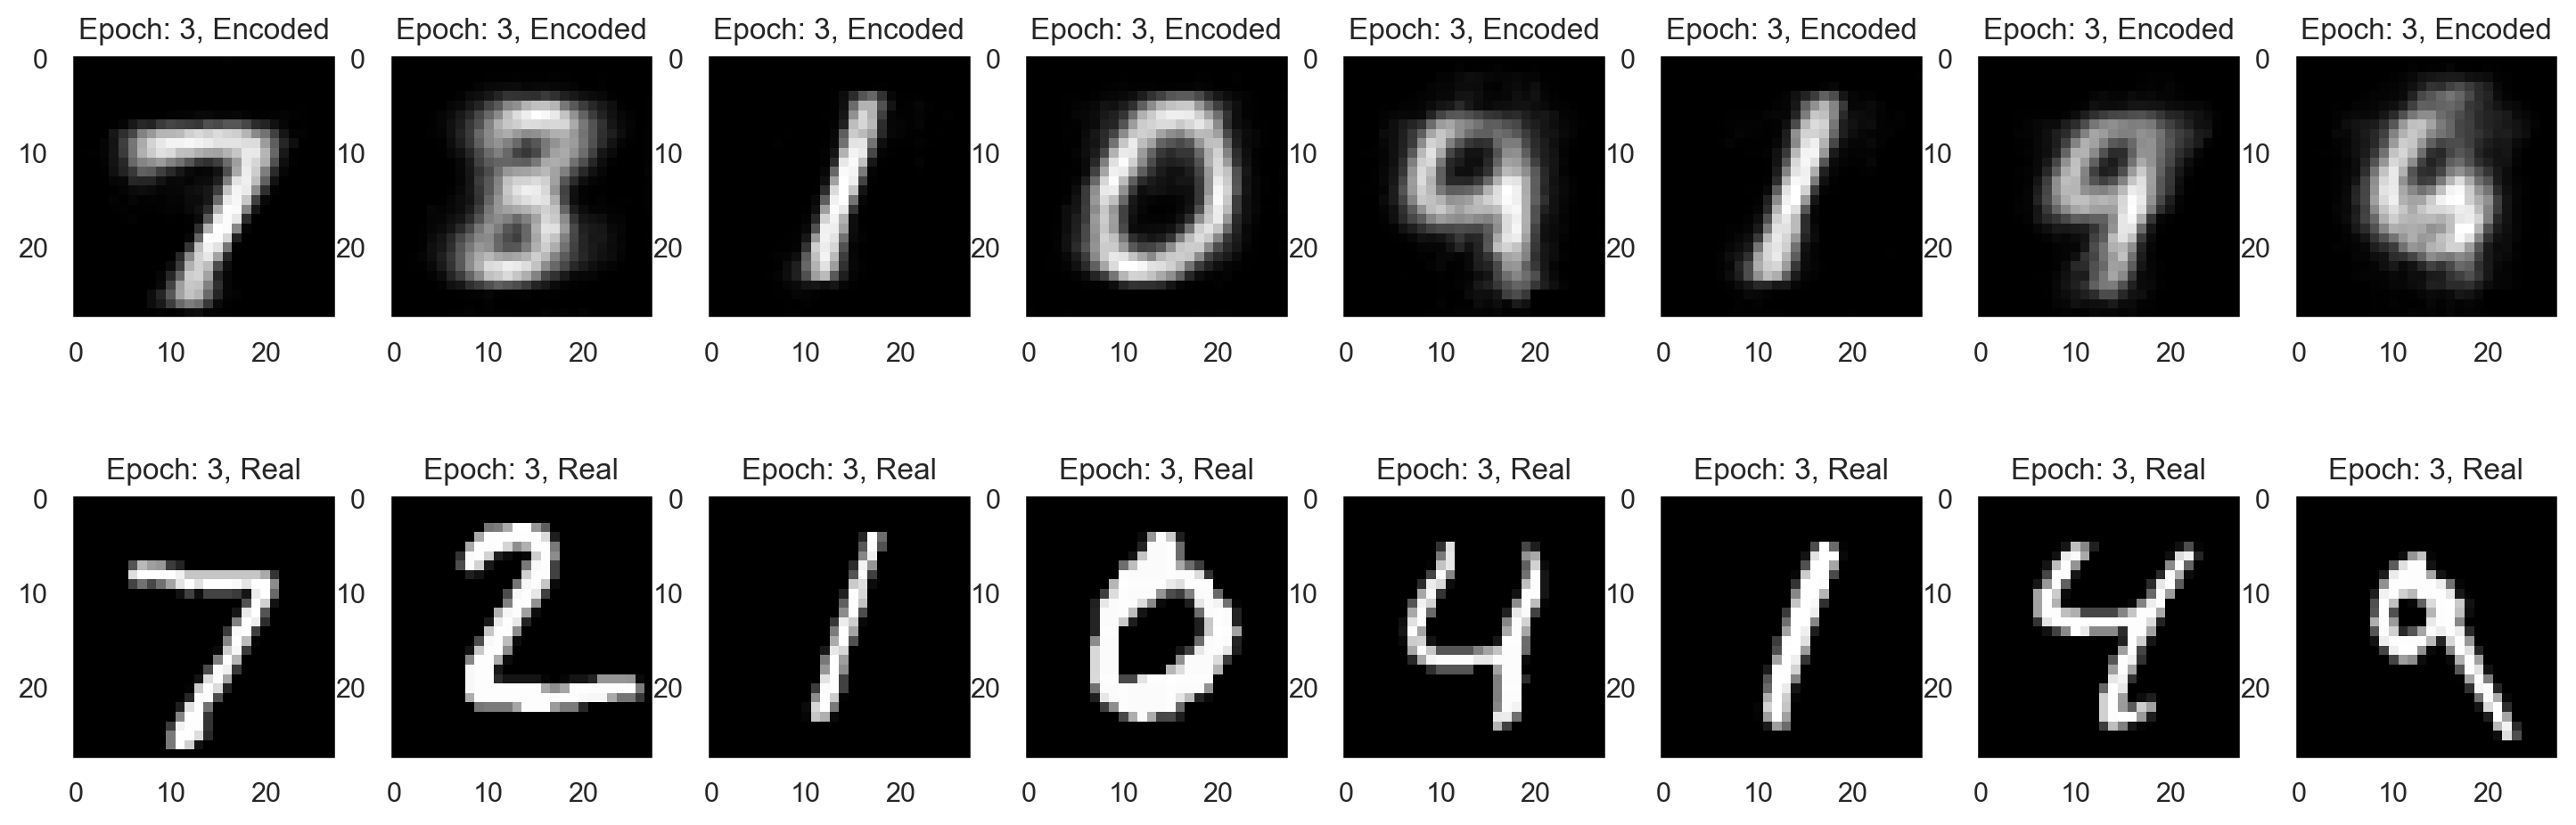

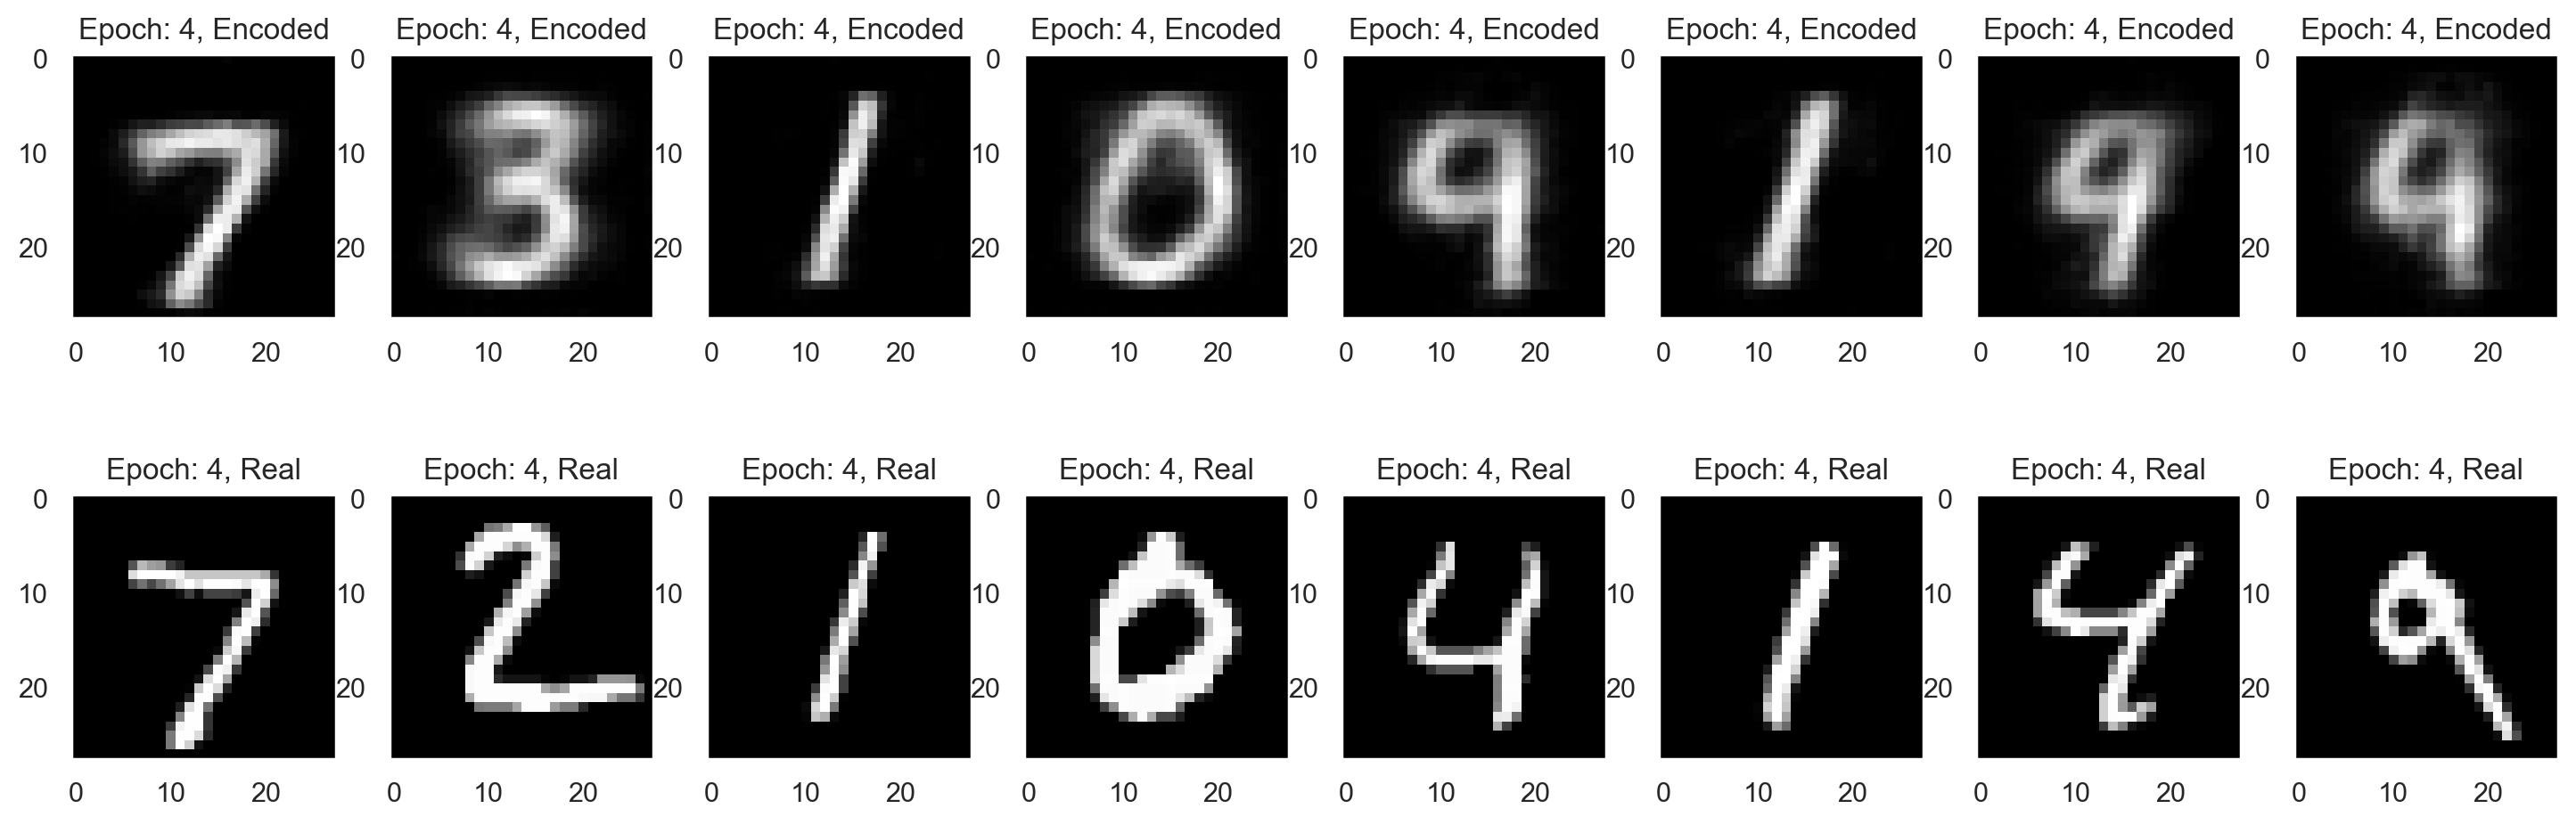

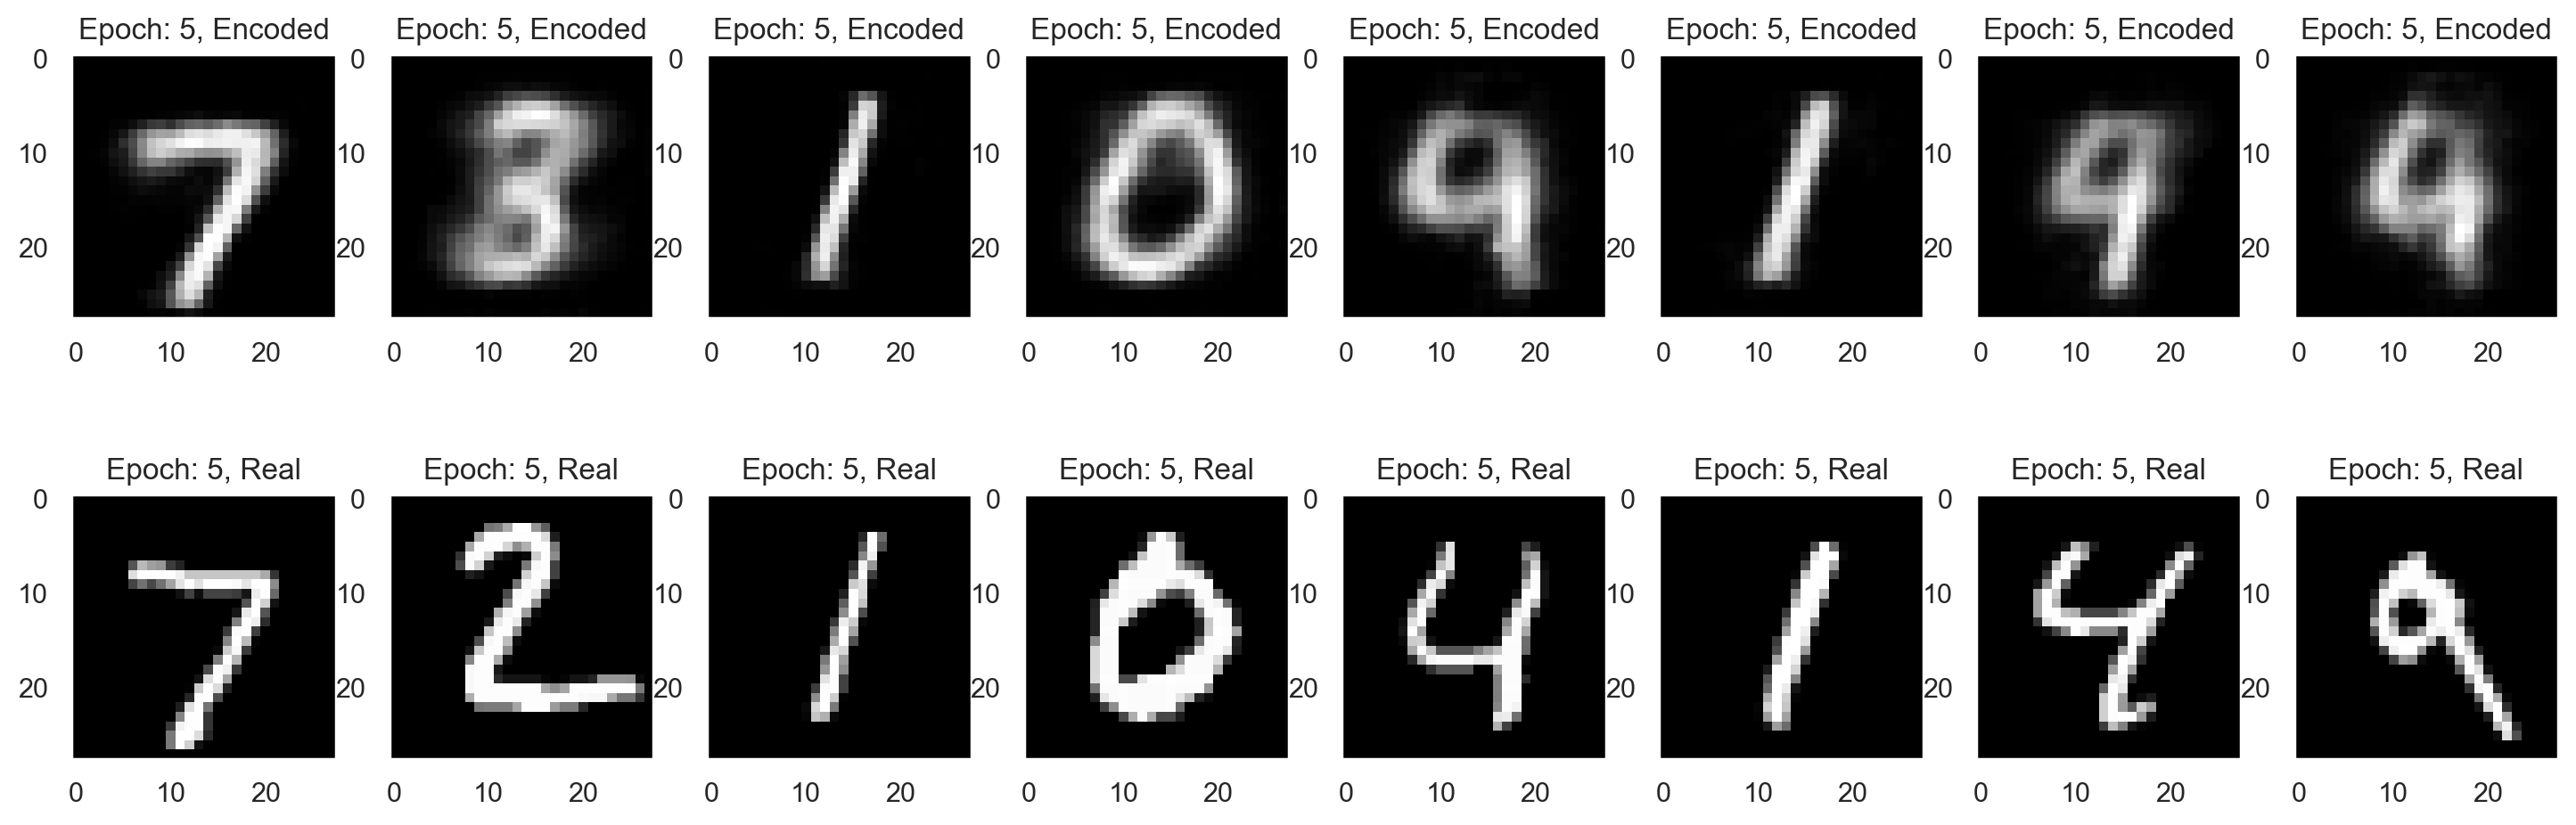

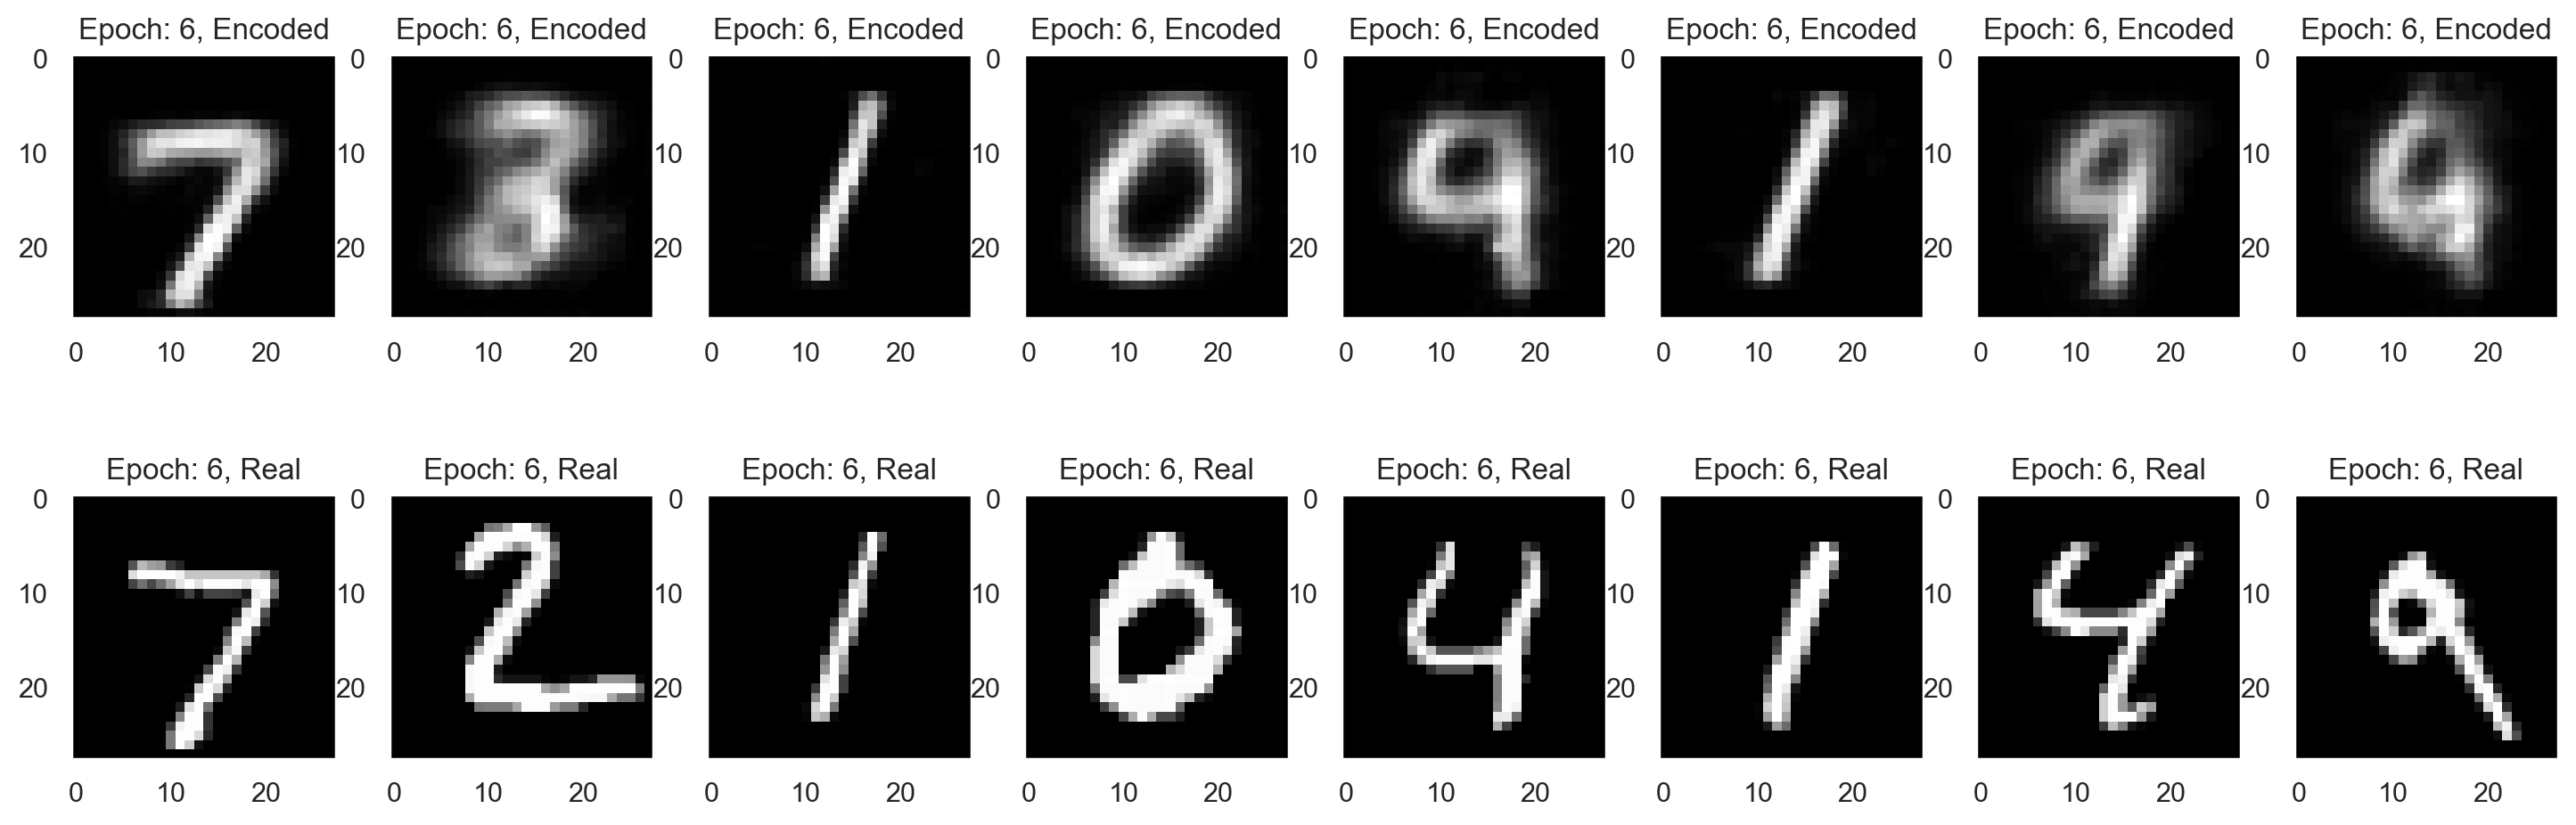

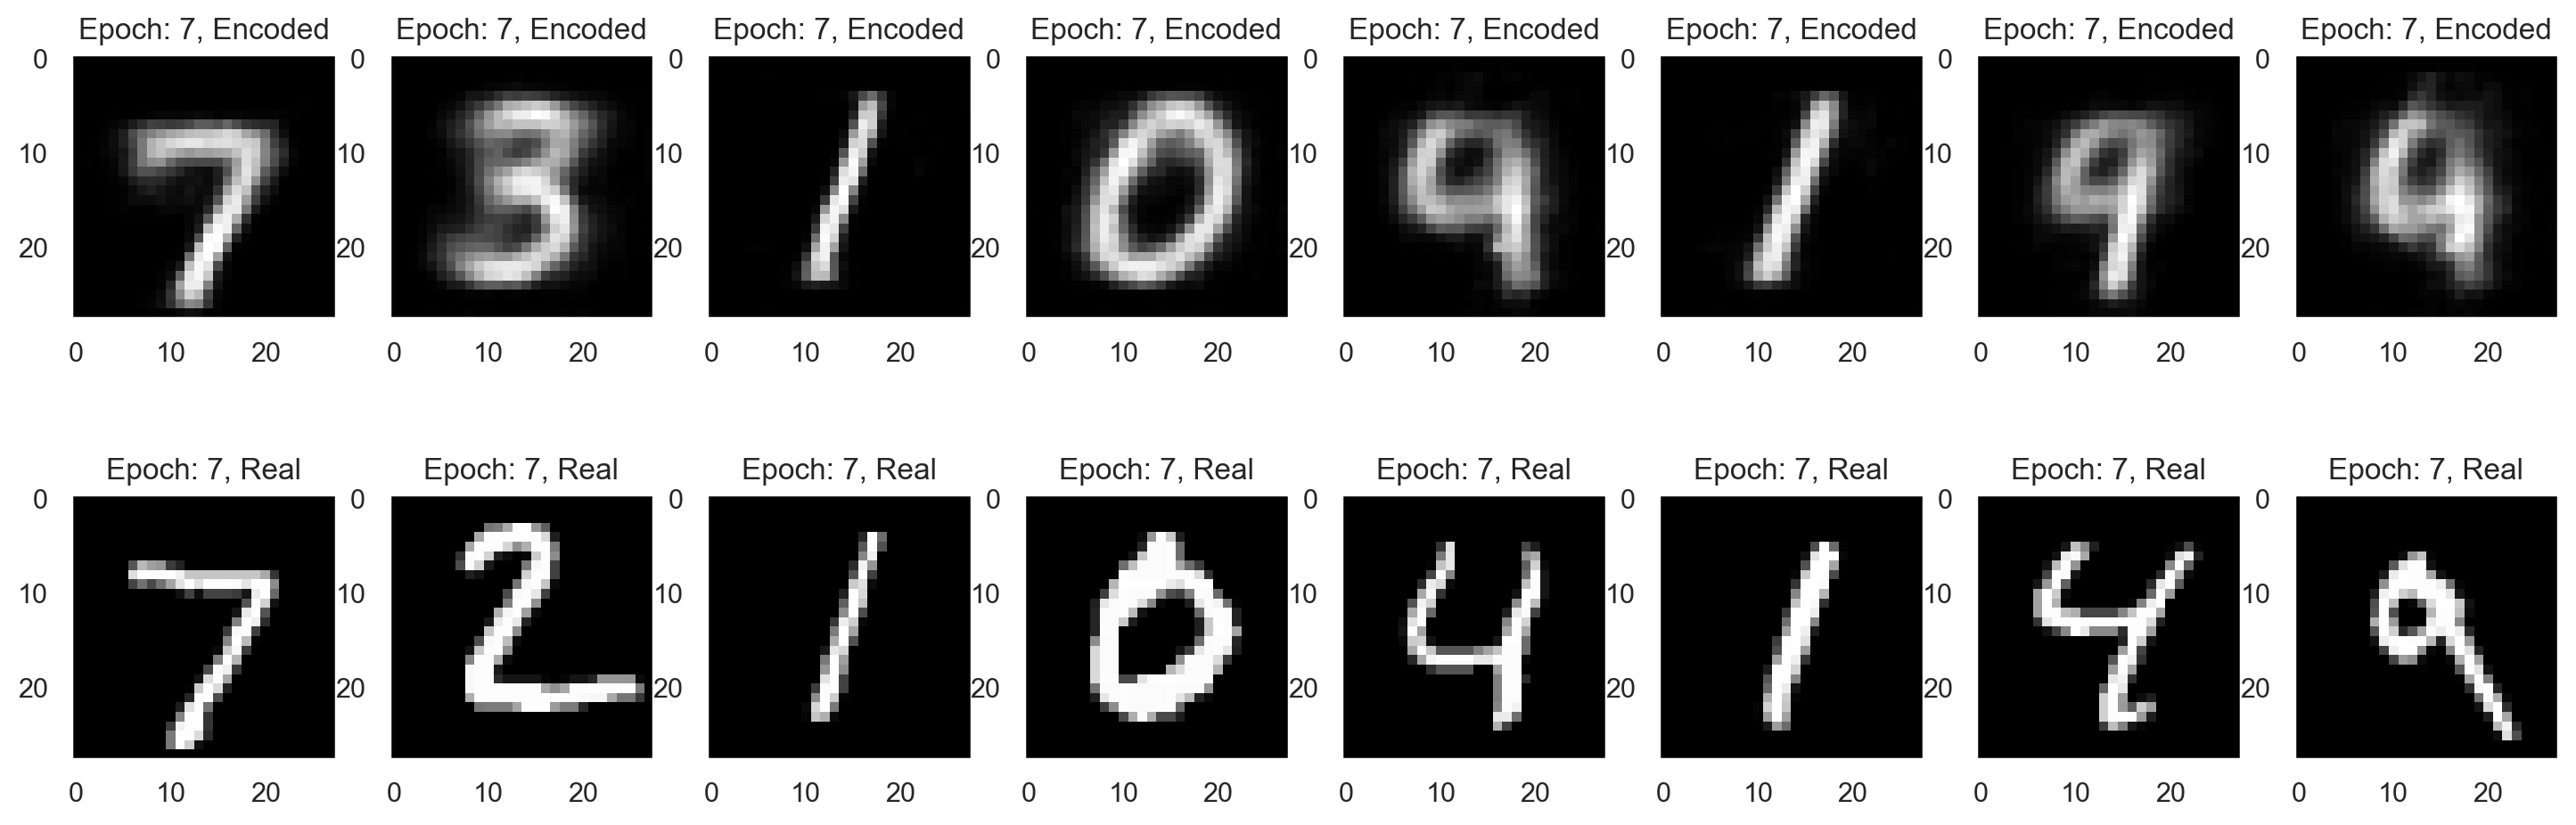

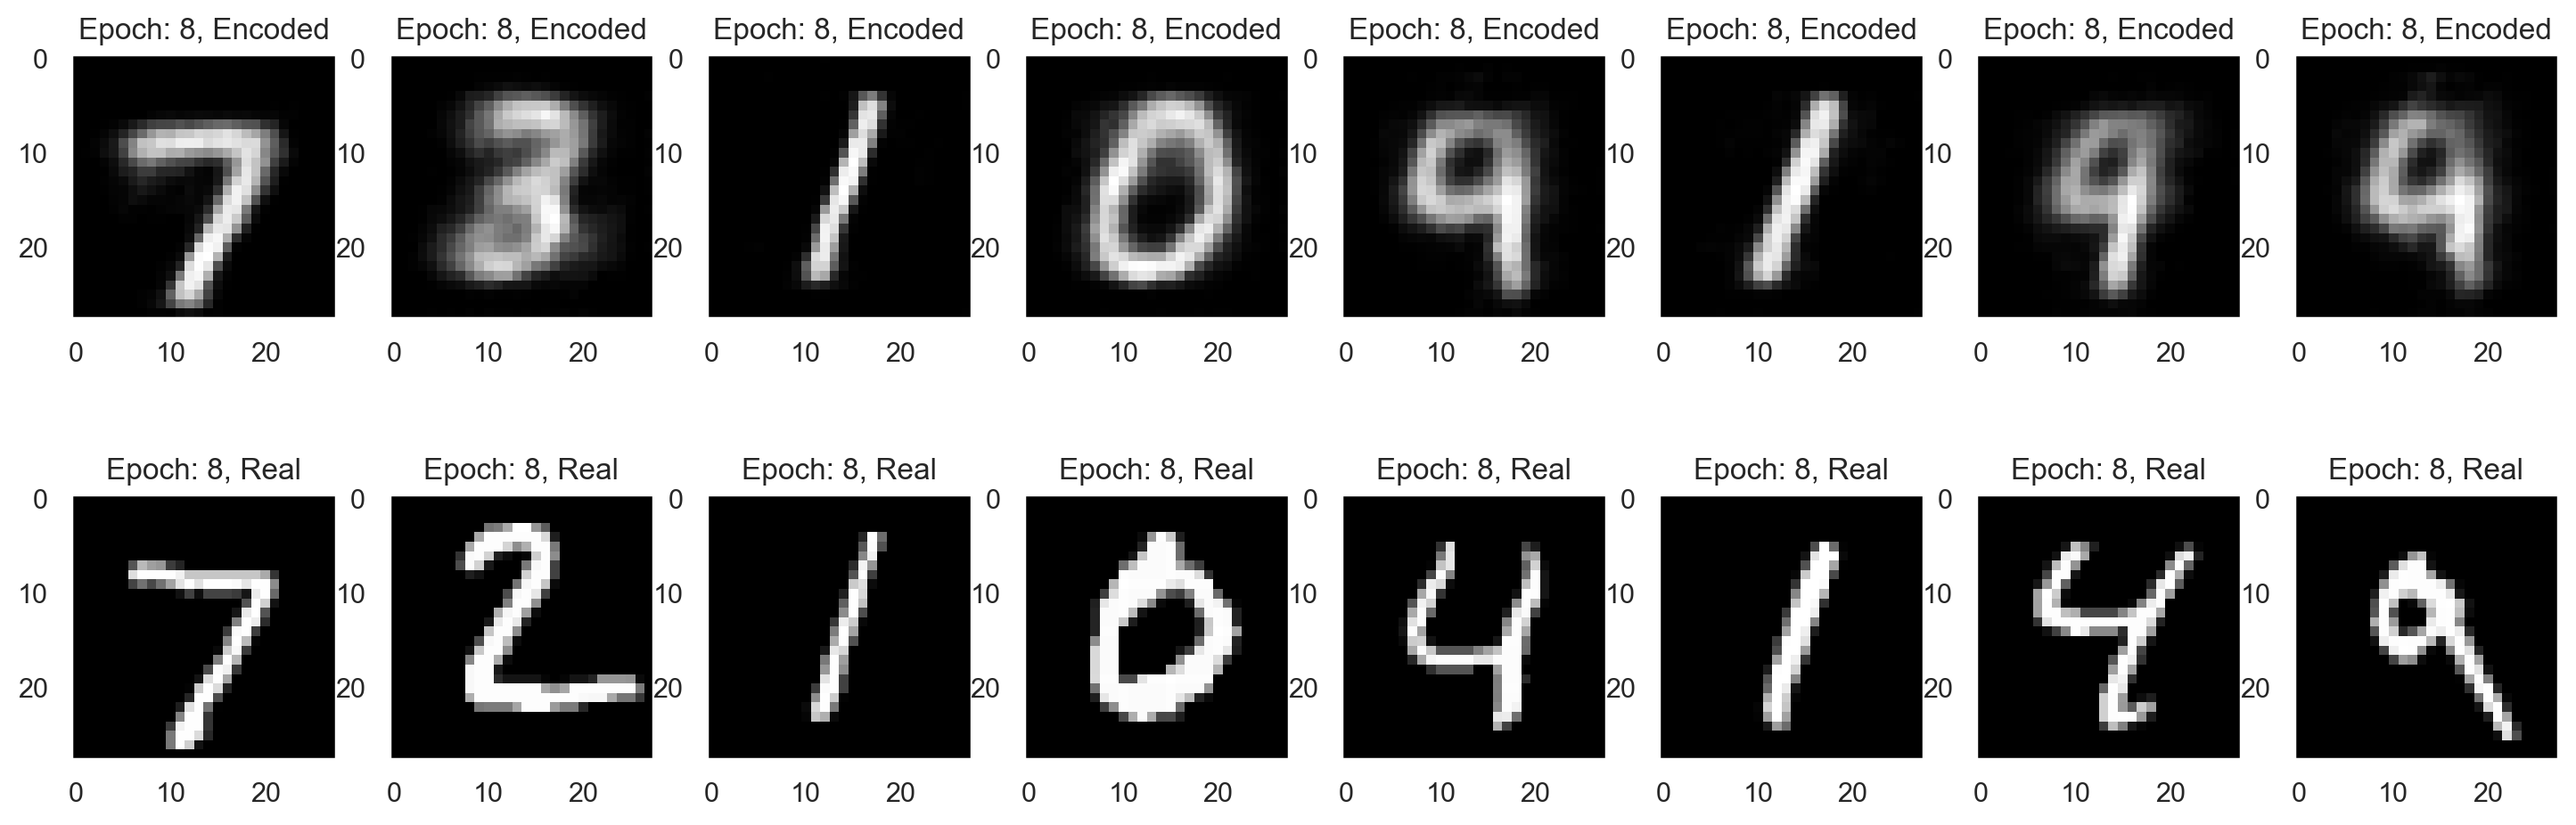

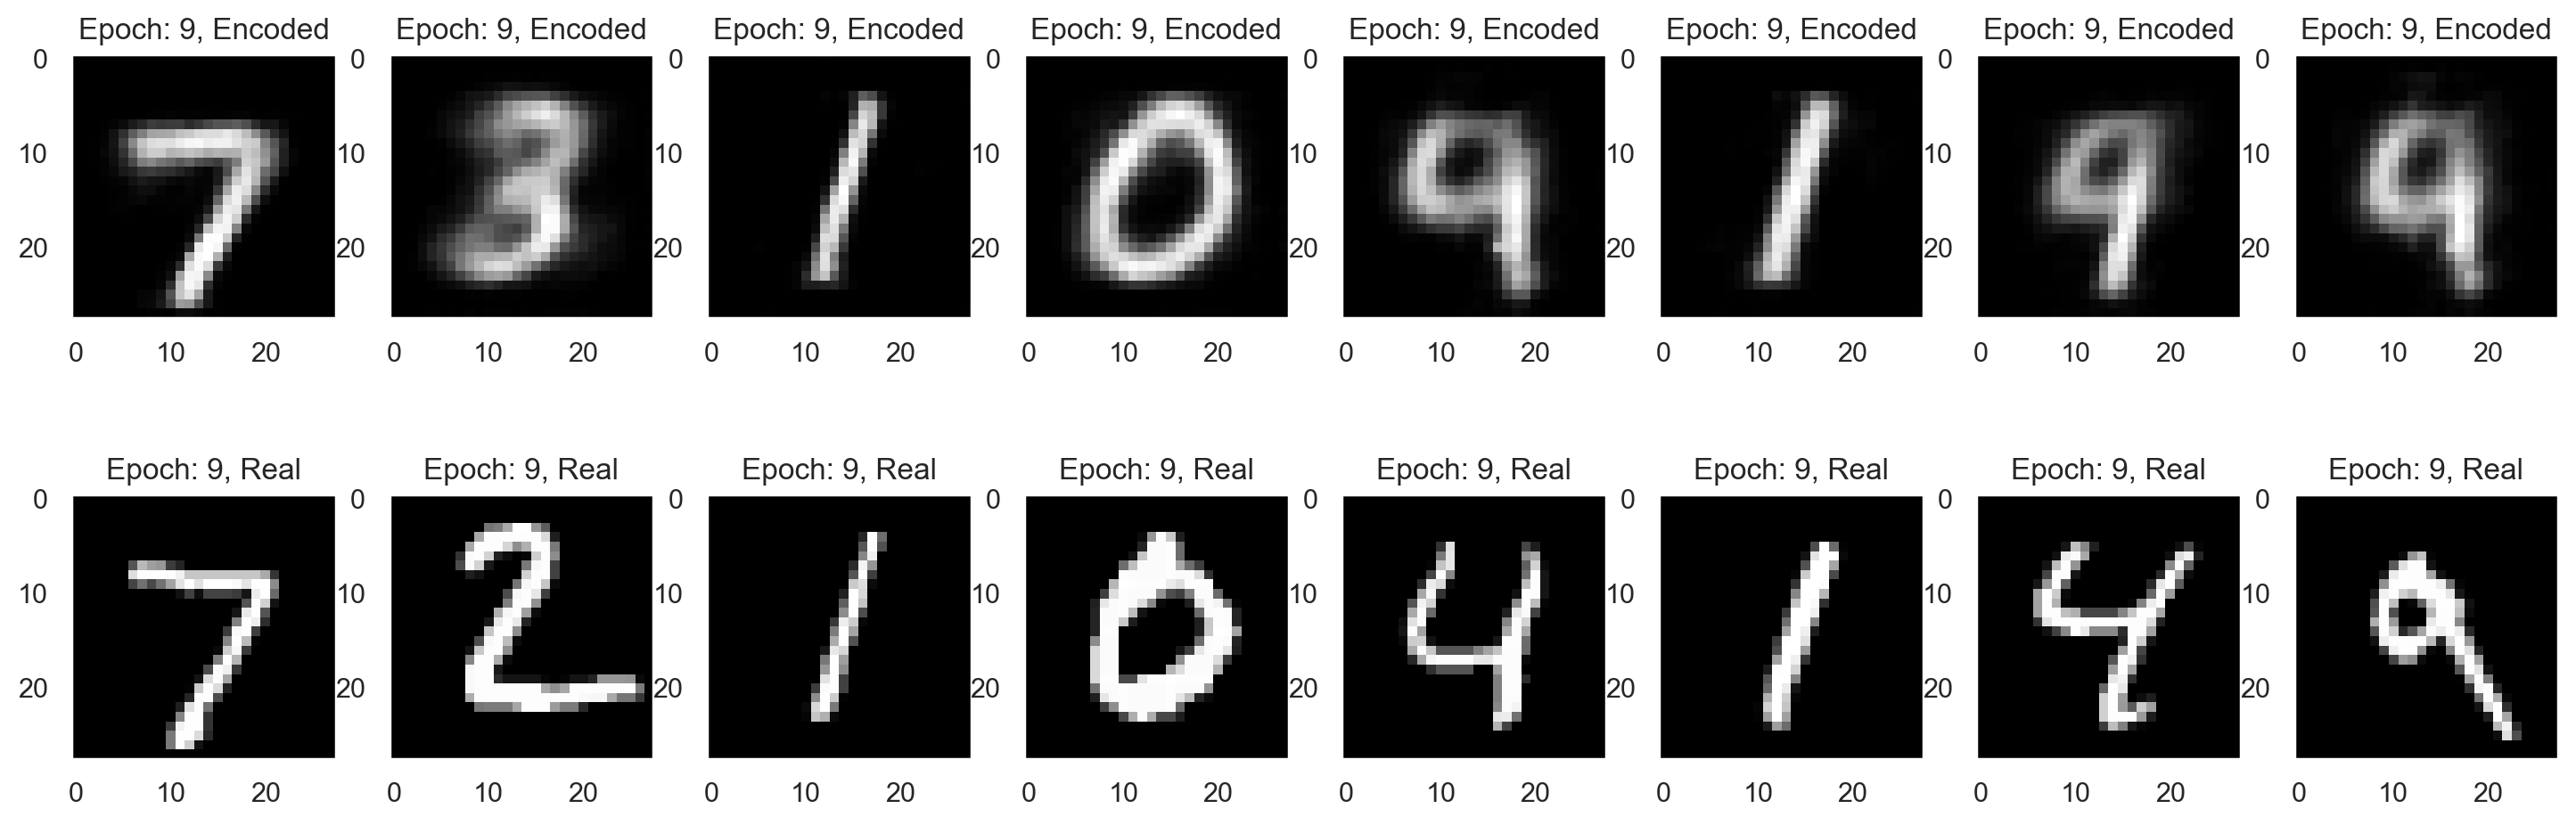

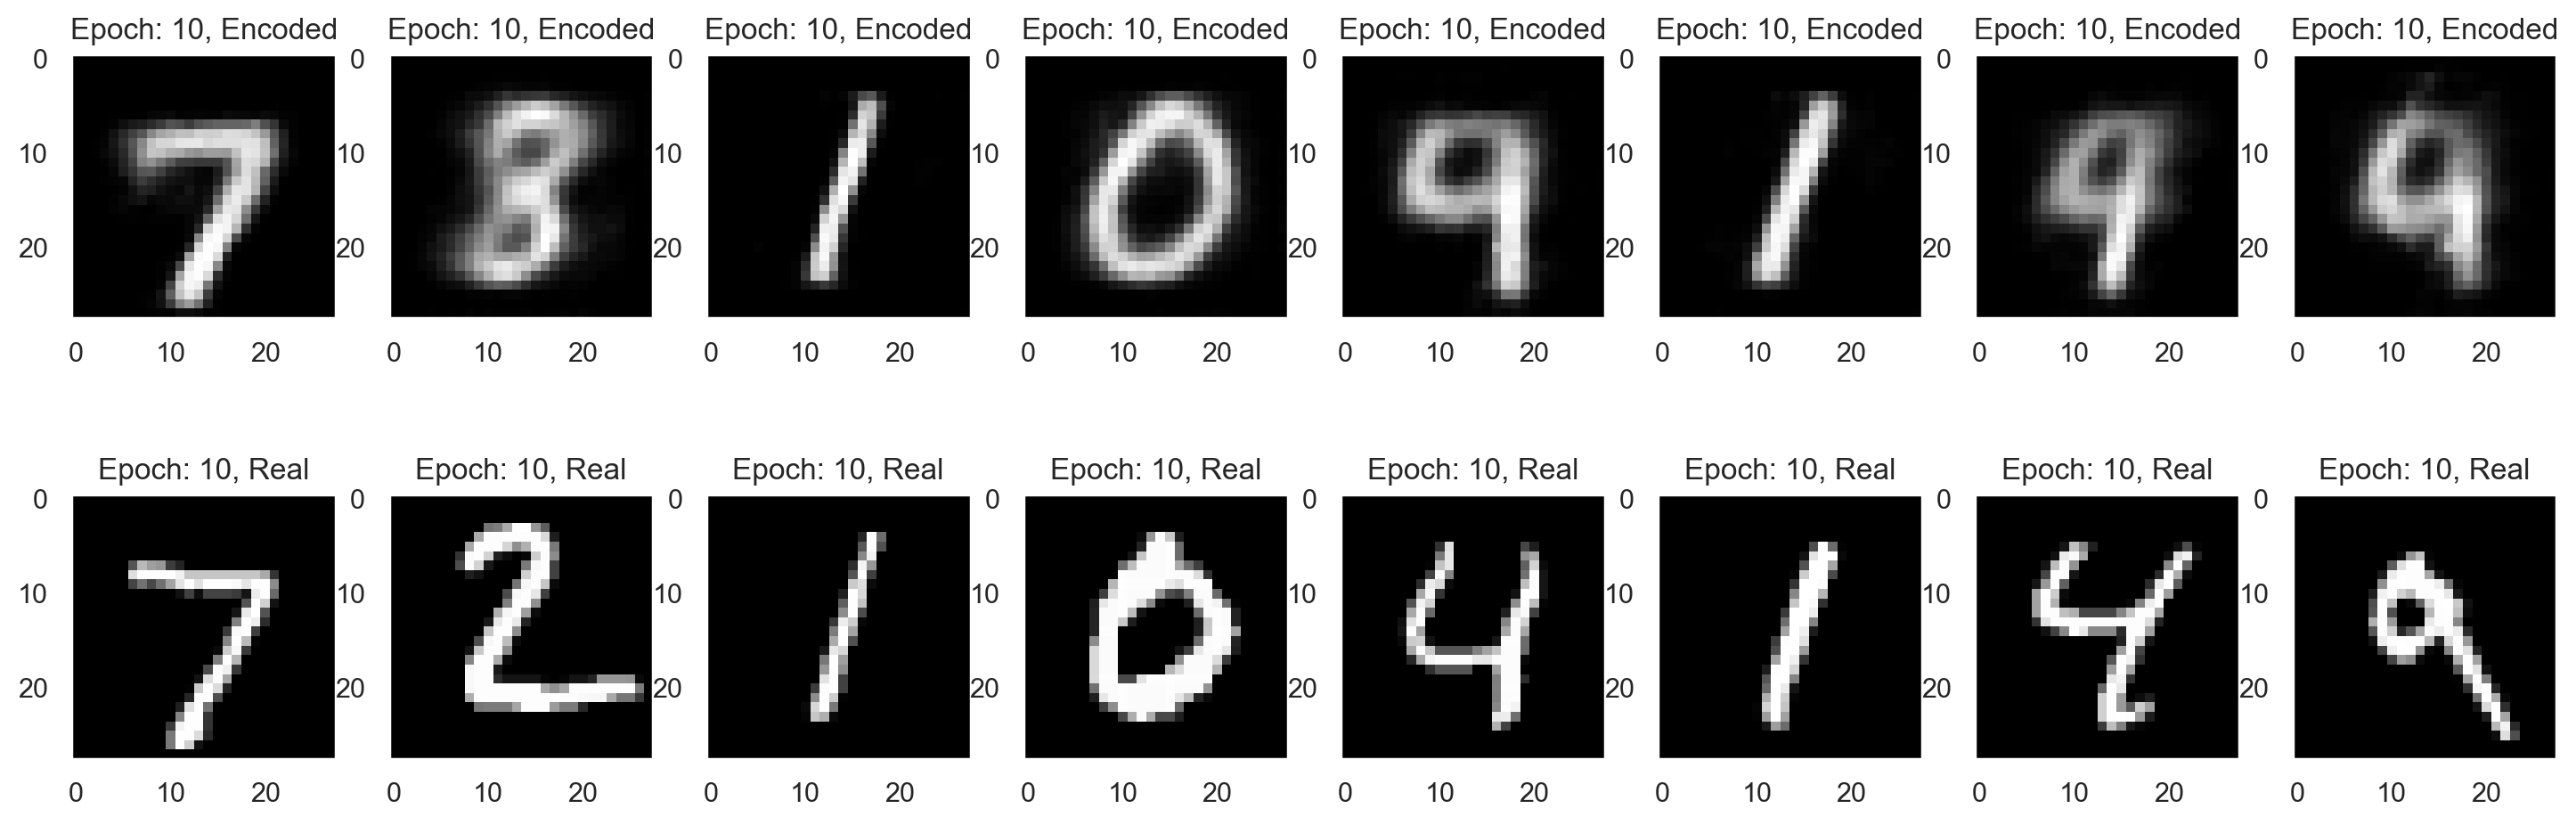

In [34]:
conv_model.plot_outputs()